##**MSc in Data Science and Economics**
*University of Milan*\
Antonella D'Amico (**961150**)

# Classification Base



1.   Set Environment
2.   Oversampling - SMOTE
3.   Undersampling - NearMiss v.2


### 1. Set Environment

Connect Google Drive to the notebook and import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/')
path = '/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/'

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, 
                                     StratifiedKFold, 
                                     GridSearchCV)

from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score, 
                             ConfusionMatrixDisplay)

# Algorithms
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as imbpipeline

from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer)
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
scaler = StandardScaler(with_mean = False)
smote = SMOTE()
Tfidf_vect = TfidfVectorizer()

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
def makeROC(classifiers, title, rocX_test, rocy_test):
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in classifiers:
        model = cls
        yproba = model.predict_proba(rocX_test)[::,1]

        fpr, tpr, _ = roc_curve(rocy_test,  yproba)
        auc = roc_auc_score(rocy_test, yproba)

        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(('ROC Curve Analysis '+title), fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

Import pre-processed dataset

In [5]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/data.pkl", "rb") as f:
    data = pickle.load(f)

In [6]:
X = data['Text_cleaned']
print(X.shape)
y = data['Label']
y.shape

(1162,)


(1162,)

In [7]:
#Split dataset in training and test set with 80/20 and stratified set to true since it is unbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 1,
                                                    stratify = y)

### 2. OverSampling - SMOTE

In [8]:
# Initializing Classifiers
clf1 = ComplementNB()
clf2 = LogisticRegression(solver='lbfgs')
clf3 = SVC(random_state=1)
clf4 = RandomForestClassifier(random_state=1)

In [9]:
tfidf_text = Tfidf_vect.fit_transform(X_train)
tfidf_text = scaler.fit_transform(tfidf_text)
X_train_smote, y_train_smote = smote.fit_resample(tfidf_text, y_train)

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#### Naive Bayes

In [12]:
param_grid1 = [{'alpha' : [0.5, 1, 10]}]
gcv_model_select = GridSearchCV(estimator=clf1,
                                param_grid=param_grid1,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 97.29%
Best parameters: {'alpha': 0.5}


#### Logistic Regression

In [11]:
param_grid2 = [{'penalty': ['l2'],
                'C': [1, 0.1, 0.01]}]
gcv_model_select = GridSearchCV(estimator=clf2,
                                param_grid=param_grid2,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 99.72%
Best parameters: {'C': 1, 'penalty': 'l2'}


#### Support Vector Machine

In [13]:
param_grid3 = [{'kernel': ['linear', 'rbf'],
                'C': [1, 0.1, 0.01]}]
gcv_model_select = GridSearchCV(estimator=clf3,
                                param_grid=param_grid3,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV accuracy: 99.79%
Best parameters: {'C': 1, 'kernel': 'linear'}


#### Random Forest

In [14]:
param_grid4 = [{'n_estimators': [100, 200, 500]}]
gcv_model_select = GridSearchCV(estimator=clf4,
                                param_grid=param_grid4,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 95.56%
Best parameters: {'n_estimators': 200}


## Save the Over Base models and plot results ans ROC curve

In [15]:
BaseNB_o = ComplementNB(alpha = 0.5).fit(X_train_smote, y_train_smote)

BaseLR_o = LogisticRegression(solver='lbfgs', C = 1, penalty = 'l2').fit(X_train_smote, y_train_smote)

BaseSVM_o = SVC(random_state=1, C = 1, kernel = 'linear', probability=True).fit(X_train_smote, y_train_smote)

BaseRF_o = RandomForestClassifier(random_state=1, n_estimators = 200).fit(X_train_smote, y_train_smote)

pkl_filename = path + "BaseNB_O.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(BaseNB_o, file)

pkl_filename = path + "BaseLR_O.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(BaseLR_o, file)

pkl_filename = path + "BaseSVM_O.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(BaseSVM_o, file)

pkl_filename = path + "BaseRF_O.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(BaseRF_o, file)

In [16]:
X_test = Tfidf_vect.transform(X_test)
X_test = scaler.transform(X_test)

In [17]:
pkl_filename = path +"BaseNB_O.pkl"
with open(pkl_filename, 'rb') as file:
    BaseNB_o = pickle.load(file)
y_pred = BaseNB_o.predict(X_test)
# Use accuracy_score function to get the accuracy
print("****Naive Bayes Report****")
print("MultinomialNB Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('\nClasification report:\n', classification_report(y_test, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(y_test, y_pred))
print()
print("*"*36)

pkl_filename = path +"BaseLR_O.pkl"
with open(pkl_filename, 'rb') as file:
    BaseLR_o = pickle.load(file)
y_pred = BaseLR_o.predict(X_test)
# Use accuracy_score function to get the accuracy
print("****Logistic Regression Report****")
print("LR Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('\nClasification report:\n', classification_report(y_test, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(y_test, y_pred))
print()
print("*"*36)

pkl_filename = path +"BaseSVM_O.pkl"
with open(pkl_filename, 'rb') as file:
    BaseSVM_o = pickle.load(file)
y_pred = BaseSVM_o.predict(X_test)
# Use accuracy_score function to get the accuracy
print("****SVM Report****")
print("SVM Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('\nClasification report:\n', classification_report(y_test, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(y_test, y_pred))
print()
print("*"*36)

pkl_filename = path +"BaseRF_O.pkl"
with open(pkl_filename, 'rb') as file:
    BaseRF_o = pickle.load(file)
y_pred = BaseRF_o.predict(X_test)
# Use accuracy_score function to get the accuracy
print("****Random Forest Report****")
print("RF Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('\nClasification report:\n', classification_report(y_test, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(y_test, y_pred))
print()
print("*"*36)

****Naive Bayes Report****
MultinomialNB Accuracy: 0.9111747851002865

Clasification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       309
           1       0.68      0.42      0.52        40

    accuracy                           0.91       349
   macro avg       0.80      0.70      0.74       349
weighted avg       0.90      0.91      0.90       349


Confussion matrix:
 [[301   8]
 [ 23  17]]

************************************
****Logistic Regression Report****
LR Accuracy: 0.9226361031518625

Clasification report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96       309
           1       0.88      0.38      0.53        40

    accuracy                           0.92       349
   macro avg       0.90      0.68      0.74       349
weighted avg       0.92      0.92      0.91       349


Confussion matrix:
 [[307   2]
 [ 25  15]]

**********************************

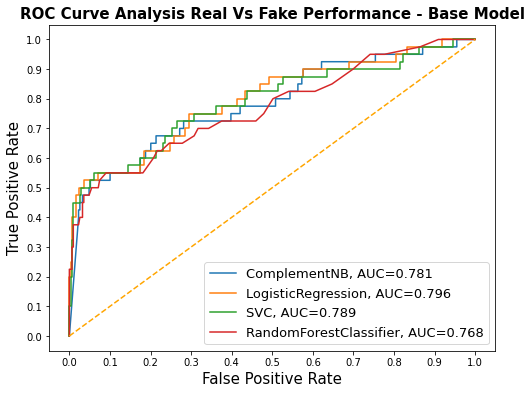

<Figure size 432x288 with 0 Axes>

In [18]:
makeROC([BaseNB_o, BaseLR_o, BaseSVM_o, BaseRF_o], "Real Vs Fake Performance - Base Model", X_test, y_test) 
plt.savefig('/content/drive/MyDrive/Master_Thesis_D_Amico/images/ROC_base_over.png')

## Undersampling - NearMiss v.2

In [35]:
from imblearn.under_sampling import NearMiss
# define the undersampling method
undersample = NearMiss(version=2)

In [36]:
# Initializing Classifiers
clf1 = ComplementNB()
clf2 = LogisticRegression(solver='lbfgs')
clf3 = SVC(random_state=1)
clf4 = RandomForestClassifier(random_state=1)

# Setting up the parameter grids
param_grid1 = [{'clf1__alpha' : [0.5, 1, 10]}]

param_grid2 = [{'clf2__penalty': ['l2'],
                'clf2__C': [1, 0.1, 0.01]}]

param_grid3 = [{'clf3__kernel' : ['linear'],
                'clf3__C' : [0.01, 0.1, 1],
                'clf3__kernel' : ['rbf'],
                'clf3__C' : [0.01, 0.1, 1]}]

param_grid4 = [{'clf4__n_estimators': [100, 200, 500]}]

In [37]:
X_train_undersampled, y_train_undersampled = undersample.fit_resample(tfidf_text, y_train)

#### Naive Bayes

In [38]:
param_grid1 = [{'alpha' : [0.5, 1, 10]}]
gcv_model_select = GridSearchCV(estimator=clf1,
                                param_grid=param_grid1,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_undersampled, y_train_undersampled)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 66.70%
Best parameters: {'alpha': 10}


#### Logistic Regression

In [39]:
param_grid2 = [{'penalty': ['l2'],
                'C': [1, 0.1, 0.01]}]
gcv_model_select = GridSearchCV(estimator=clf2,
                                param_grid=param_grid2,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_undersampled, y_train_undersampled)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 63.44%
Best parameters: {'C': 1, 'penalty': 'l2'}


#### Support Vector Machine

In [40]:
param_grid3 = [{'kernel': ['linear', 'rbf'],
                'C': [1, 0.1, 0.01]}]
gcv_model_select = GridSearchCV(estimator=clf3,
                                param_grid=param_grid3,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_undersampled, y_train_undersampled)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV accuracy: 92.45%
Best parameters: {'C': 1, 'kernel': 'rbf'}


#### Random Forest

In [41]:
param_grid4 = [{'n_estimators': [100, 200, 500]}]
gcv_model_select = GridSearchCV(estimator=clf4,
                                param_grid=param_grid4,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_undersampled, y_train_undersampled)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 83.29%
Best parameters: {'n_estimators': 500}


## Save the Under Base Models and plot the results and ROC curve

In [42]:
BaseNB_u = ComplementNB(alpha = 10).fit(X_train_undersampled, y_train_undersampled)

BaseLR_u = LogisticRegression(solver='lbfgs', C = 1, penalty = 'l2').fit(X_train_undersampled, y_train_undersampled)

BaseSVM_u = SVC(random_state=1, C = 1, kernel = 'rbf', probability=True).fit(X_train_undersampled, y_train_undersampled)

BaseRF_u = RandomForestClassifier(random_state=1, n_estimators = 500).fit(X_train_undersampled, y_train_undersampled)

pkl_filename = path + "BaseNB_u.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(BaseNB_u, file)

pkl_filename = path +  "BaseLR_u"
with open(pkl_filename, 'wb') as file:
    pickle.dump(BaseLR_u, file)

pkl_filename = path + "BaseSVM_u"
with open(pkl_filename, 'wb') as file:
    pickle.dump(BaseSVM_u, file)

pkl_filename = path + "BaseRF_u"
with open(pkl_filename, 'wb') as file:
    pickle.dump(BaseRF_u, file)

In [47]:
pkl_filename = path + "BaseNB_u.pkl"
with open(pkl_filename, 'rb') as file:
    BaseNB_u  = pickle.load(file)
y_pred = BaseNB_u .predict(X_test)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('\nClasification report:\n', classification_report(y_test, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(y_test, y_pred))
print()
print("*"*36)

pkl_filename = path +  "BaseLR_u"
with open(pkl_filename, 'rb') as file:
    BaseLR_u = pickle.load(file)
y_pred = BaseLR_u.predict(X_test)
# Use accuracy_score function to get the accuracy
print("****Logistic Regression Report****")
print("LR Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('\nClasification report:\n', classification_report(y_test, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(y_test, y_pred))
print()
print("*"*36)

pkl_filename = path +  "BaseSVM_u"
with open(pkl_filename, 'rb') as file:
    BaseSVM_u  = pickle.load(file)
y_pred = BaseSVM_u.predict(X_test)
# Use accuracy_score function to get the accuracy
print("****SVM Report****")
print("SVM Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('\nClasification report:\n', classification_report(y_test, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(y_test, y_pred))
print()
print("*"*36)

pkl_filename = path +  "BaseRF_u"
with open(pkl_filename, 'rb') as file:
    BaseRF_u = pickle.load(file)
y_pred = BaseRF_u.predict(X_test)
# Use accuracy_score function to get the accuracy
print("****Random Forest Report****")
print("RF Accuracy:", metrics.accuracy_score(y_test, y_pred))
print('\nClasification report:\n', classification_report(y_test, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(y_test, y_pred))
print()
print("*"*36)

****NB Report****
MultinomialNB Accuracy: 0.7822349570200573

Clasification report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.87       309
           1       0.29      0.62      0.40        40

    accuracy                           0.78       349
   macro avg       0.62      0.71      0.63       349
weighted avg       0.87      0.78      0.81       349


Confussion matrix:
 [[248  61]
 [ 15  25]]

************************************
****Logistic Regression Report****
LR Accuracy: 0.8796561604584527

Clasification report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       309
           1       0.47      0.45      0.46        40

    accuracy                           0.88       349
   macro avg       0.70      0.69      0.70       349
weighted avg       0.88      0.88      0.88       349


Confussion matrix:
 [[289  20]
 [ 22  18]]

************************************
****SV

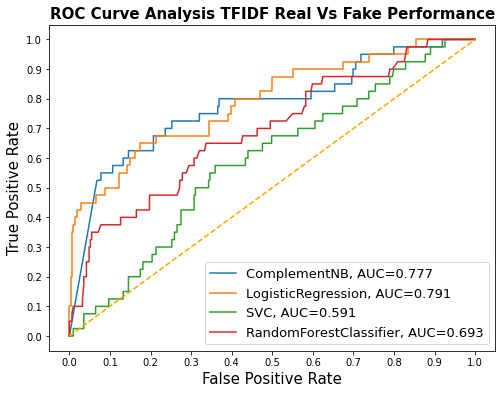

<Figure size 432x288 with 0 Axes>

In [ ]:
makeROC([BaseNB_u, BaseLR_u, BaseSVM_u, BaseRF_u], "TFIDF Real Vs Fake Performance", X_test, y_test)
plt.savefig('/content/drive/MyDrive/Master_Thesis_D_Amico/images/ROC_base_under.png')